In [168]:
# Checkout www.pygimli.org for more examples


# Based on pg example notebook:  3D gravity modelling and inversion

Based on the synthetic model of Li & Oldenburg (1998), we demonstrate 3D
inversion of magnetic data. The forward operator bases on the formula given by
Holstein et al. (2007).


In [169]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.viewer import pv
from pygimli.utils.utils import ProgressBar
import pandas as pd
    

In [170]:
from pygimli.viewer.pv import drawStreamLines, drawSlice

In [171]:
class GravityModelling(pg.frameworks.MeshModelling):
    """Magnetics modelling operator using Holstein (2007)."""

    def __init__(self, mesh, points, cmp=["gz"], foot=None):
        """Setup forward operator.

        Parameters
        ----------
        mesh : pygimli:mesh
            tetrahedral or hexahedral mesh
        points : list|array of (x, y, z)
            measuring points
        cmp : list of str
            component of: gx, gy, gz, TFA, Bx, By, Bz, Bxy, Bxz, Byy, Byz, Bzz
        """
        # check if components do not contain g!
        super().__init__(mesh=mesh)
        self.createRefinedForwardMesh(refine=False, pRefine=False)
        self.mesh_ = mesh
        self.sensorPositions = points
        self.components = cmp
        self.footprint = foot
        self.kernel = None
        self.J = pg.matrix.BlockMatrix()
        self.createKernel()

    def createKernel(self):
        """Create computational kernel."""
        self.kernel = SolveGravMagHolstein(self.mesh_,
                                           pnts=self.sensorPositions,
                                           cmp=self.components,
                                           foot=self.footprint)
        self.J = pg.matrix.BlockMatrix()
        self.Ki = []
        self.Ji = []
        for iC in range(self.kernel.shape[1]):
            self.Ki.append(np.squeeze(self.kernel[:, iC, :]))
            self.Ji.append(pg.matrix.NumpyMatrix(self.Ki[-1]))
            self.J.addMatrix(self.Ji[-1], iC*self.kernel.shape[0], 0)

        self.J.recalcMatrixSize()
        self.setJacobian(self.J)


    def setMesh(self, mesh, ignoreRegionManager=False):
        """Set the mesh."""
        super().setMesh(mesh, ignoreRegionManager=False)
        self.createKernel(mesh)


    def response(self, model):
        """Compute forward response."""
        return self.J.dot(model)

    def createJacobian(self, model):
        """Do nothing as this is a linear problem."""

In [172]:
def SolveGravMagHolstein(mesh, pnts, cmp, igrf=None, foot=np.inf):
    """Solve gravity and/or magnetics problem after Holstein (1997).

    Parameters
    ----------
    mesh : pygimli:mesh
        tetrahedral or hexahedral mesh
    pnts : list|array of (x, y, z)
        measuring points
    cmp : list of str
        component list of: gx, gy, gz, TFA, Bx, By, Bz, Bxy, Bxz, Byy, Byz, Bzz
    igrf : list|array of size 3 or 7
        international geomagnetic reference field, either
        [D, I, H, X, Y, Z, F] - declination, inclination, horizontal field,
                               X/Y/Z components, total field OR
        [X, Y, Z] - X/Y/Z components

    Returns
    -------
    out : ndarray (nPoints x nComponents x nCells)
        kernel matrix to be multiplied with density or susceptibility
    """
    if pnts is None:
        pnts = [[0.0, 0.0]]

    doG = np.any([c[0] == "g" for c in cmp])
    doB = np.any([c[0] == "B" and len(c) == 2 for c in cmp]) or "TFA" in cmp
    doBT = np.any([c[0] == "B" and len(c) == 3 for c in cmp])
    B_tens = None

    kernel = np.zeros((mesh.cellCount(), len(pnts), len(cmp)))
    if igrf:
        if len(igrf) == 3:  # an X, Y, Z vector
            F = np.linalg.norm(igrf)
            fakt = F / (4*np.pi)
            B_dir = np.array(igrf) / F
        elif len(igrf) == 7:  # an IGRF vector (D, I, H, X, Y, Z, F)
            fakt = igrf[6] / (4*np.pi)
            myigrf = np.array(igrf[3:6])
            B_dir = myigrf / np.linalg.norm(myigrf)
        else:
            raise Exception("Could not use IGRF vector. Len must be 3 or 7!")
    elif doB or doB:
        raise Exception("Specify IGRF!")

    b_list, c_list = [], []
    for bd in mesh.boundaries():
        b_list.append([n.id() for n in bd.allNodes()])
        c_list.append([bd.leftCell(), bd.rightCell()])

    b_list = np.array(b_list)
    lb = b_list.shape

    n_list = np.array([n.pos() for n in mesh.nodes()])

    cl, cr = [], []
    for i, c in enumerate(c_list):
        if c[0]:
            cl.append([i, c[0].id()])
        if c[1]:
            cr.append([i, c[1].id()])

    cl = np.array(cl)
    cr = np.array(cr)

    rr = range(0, mesh.cellCount())
    rs = np.roll(range(0, lb[1]), -1)

    temp = np.zeros((len(pnts), lb[0], len(cmp)))
    pBar = ProgressBar(its=len(pnts), width=40, sign='+')
    nb = n_list[b_list]
    for i, p in enumerate(pnts):
        r1 = nb - p
        r2 = r1[:, rs, :]
        r0 = r2 - r1
        u = np.sum(np.cross(r1, r2), 1)
        u = u / np.expand_dims(np.linalg.norm(u, axis=1), axis=1)
        ut = np.tile(u, lb[1]).reshape((lb[0], lb[1], 3))
        ll = np.linalg.norm(r0, axis=2)
        t = r0/np.expand_dims(ll, axis=2)
        lm = (np.sum(r1*t, 2) + np.sum(r2*t, 2)) / 2
        h = np.cross(t, ut)
        hn = np.sum(h*r1, 2)
        v = np.sum(ut*r1, 2)
        r1n = np.linalg.norm(r1, axis=2)
        r2n = np.linalg.norm(r2, axis=2)
        rm = (r1n+r2n)/2
        lumbda = ll/(2*rm)

        jj = 0
        if doG: # gravitational field
            g = hn*np.arctanh(lumbda)-np.sign(v)*v*np.arctan2(
                hn*lumbda, (rm*(1-lumbda**2)+abs(v)))
            g_vec = 2 * u * np.expand_dims(np.sum(g, 1), axis=1)

            if 'g' in cmp:
                temp[i, :, jj] = g
                jj += 0

            if 'gx' in cmp:
                temp[i, :, jj] = g_vec[:, 0]
                jj += 1

            if 'gy' in cmp:
                temp[i, :, jj] = g_vec[:, 1]
                jj += 1

            if 'gz' in cmp:
                temp[i, :, jj] = g_vec[:, 2]
                jj += 1

            # if 'gxx' in cmp:
            #     temp[:, jj]=G_tens[:, 0, 0]
            # if 'gxy' in cmp:
            #     temp[:, jj]=G_tens[:, 0, 1]
            # if 'gxz' in cmp:
            #     temp[:, jj]=G_tens[:, 0, 2]
            # if 'gyy' in cmp:
            #     temp[:, jj]=G_tens[:, 1, 1]
            # if 'gyz' in cmp:
            #     temp[:, jj]=G_tens[:, 1, 2]
            # if 'gzz' in cmp:
            #     temp[:, jj]=G_tens[:, 2, 2]

        if doB or doBT:
            # magnetic field vector and gravity gradient tensor
            b = h*np.expand_dims(np.arctanh(lumbda), axis=2) - \
                ut*np.expand_dims(np.sign(v)*np.arctan2(
                    hn*lumbda, (rm*(1-lumbda**2)+abs(v))), axis=2)
            P = np.dot(u, B_dir)
            B_vec = np.expand_dims(P, 1) * np.sum(b, 1)
            B_vec = 2 * np.expand_dims(P, 1) * np.sum(b, 1)

            if 'TFA' in cmp:
                temp[i, :, jj] = fakt*B_vec.dot(B_dir)
                jj += 1

            if 'Bx' in cmp:
                temp[i, :, jj] = fakt*B_vec[:, 0]
                jj += 1

            if 'By' in cmp:
                temp[i, :, jj] = fakt*B_vec[:, 1]
                jj += 1

            if 'Bz' in cmp:
                temp[i, :, jj] = fakt*B_vec[:, 2]
                jj += 1

            if doBT:  # magnetic gradient tensor
                d = (-2*lumbda*hn) / (r1n*r2n*(1-lumbda**2))
                e = (-2*lumbda*lm) / (r1n*r2n)
                f = (-2*lumbda*v) / (r1n*r2n*(1-lumbda**2))

                h1 = np.expand_dims(h, axis=3)
                h2 = np.swapaxes(h1, 2, 3)
                t1 = np.expand_dims(t, axis=3)
                t2 = np.swapaxes(t1, 2, 3)
                u1 = np.expand_dims(ut, axis=3)
                u2 = np.swapaxes(u1, 2, 3)

                B = (h1*h2-u1*u2)*np.expand_dims(d, (2, 3)) + \
                    (t1*h2+h1*t2)*np.expand_dims(e, (2, 3))/2 + \
                    (h1*u2+u1*h2)*np.expand_dims(f, (2, 3))

                B_tens = np.expand_dims(P, (1, 2)) * np.sum(B, 1)

                if 'Bxx' in cmp:
                    temp[i, :, jj] = fakt*B_tens[:, 0, 0]
                    jj += 1

                if 'Bxy' in cmp:
                    temp[i, :, jj] = fakt*B_tens[:, 0, 1]
                    jj += 1

                if 'Bxz' in cmp:
                    temp[i, :, jj] = fakt*B_tens[:, 0, 2]
                    jj += 1

                if 'Byy' in cmp:
                    temp[i, :, jj] = fakt*B_tens[:, 1, 1]
                    jj += 1

                if 'Byz' in cmp:
                    temp[i, :, jj] = fakt*B_tens[:, 1, 2]
                    jj += 1

                if 'Bzz' in cmp:
                    temp[i, :, jj] = fakt * B_tens[:, 2, 2]
                    jj += 1

    pBar.update(i)
    kernel += np.array([np.sum(temp[:, cl[cl[:, 1] == j, 0]], 1) for j in rr])
    kernel -= np.array([np.sum(temp[:, cr[cr[:, 1] == j, 0]], 1) for j in rr])

    return kernel.transpose([1, 2, 0])

## Synthetic model generation and data import





In [173]:
#service desk suggestion so that the figures run on cluster 
import pyvista
pyvista.start_xvfb() 


In [174]:
#dataset = pd.read_csv('C:/RWTH_Aachen/thesis/july_bash/gravity_processed.csv')
dataset = pd.read_csv('gravity_processed.csv')
dataset


,Unnamed: 0,Point ID,Observed Value [mGal],Time,Voltage [V],Temperature [°C],Altitude,Counter Reading,Remark,Date,...,gravity_bouger_corrected1800,gravity_bouger_corrected2000,gravity_bouger_corrected2200,gravity_bouger_corrected2400,gravity_bouger_corrected2600,bouger_rho_delta,regional,residual,CORRECTEDx,CORRETED
0,0,8001,4864.713210,01/01/1900 13:04,12.6,50.0,9,4754.50,Base Station I,6.12.2022,...,-1.830114,-2.177489,-2.524865,-2.872241,-3.219617,-1.389503,-2.970344,-0.370854,218366.5117,381192.5130
1,1,8002,4865.533514,01/01/1900 13:14,12.6,50.0,13,4755.30,NaN,6.12.2022,...,-1.742500,-2.066245,-2.389990,-2.713735,-3.037480,-1.294980,-2.910675,-0.240115,218569.6151,381290.6376
2,2,8003,4866.251280,01/01/1900 13:22,12.5,50.0,16,4756.00,NaN,6.12.2022,...,-1.446642,-1.757429,-2.068215,-2.379002,-2.689789,-1.243147,-2.890922,0.092358,218743.2993,381370.5864
3,3,8004,4866.456356,01/01/1900 13:32,12.5,50.0,18,4756.20,NaN,6.12.2022,...,-1.467691,-1.768938,-2.070184,-2.371430,-2.672677,-1.204985,-2.882718,0.104606,218878.7973,381323.1159
4,4,8005,4867.174122,01/01/1900 13:41,12.6,50.0,18,4756.90,Changing voltage,6.12.2022,...,-1.665391,-1.934787,-2.204183,-2.473579,-2.742975,-1.077584,-2.946030,0.108766,219216.5121,381365.4320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,119,4009,4868.712192,01/01/1900 15:42,12.6,49.9,35,4758.40,city centre,19.12.2022,...,-2.318108,-2.653658,-2.989208,-3.324757,-3.660308,-1.342200,-4.464294,0.686545,216181.9902,384866.4828
120,120,4010,4867.276660,01/01/1900 15:51,12.6,49.9,38,4757.00,city centre,19.12.2022,...,-3.007134,-3.369166,-3.731198,-4.093230,-4.455263,-1.448130,-5.309931,0.727956,215712.4380,384844.2620
121,121,4011,4865.789859,01/01/1900 15:55,12.6,49.9,41,4755.55,NaN,19.12.2022,...,-4.027522,-4.408698,-4.789874,-5.171050,-5.552226,-1.524704,-6.430891,0.745253,215180.8298,384919.1373
122,122,4012,4866.046204,01/01/1900 16:01,12.6,49.9,33,4755.80,NaN,19.12.2022,...,-5.969700,-6.274574,-6.579448,-6.884321,-7.189195,-1.219495,-7.483186,0.187286,214748.6012,385009.7034


In [175]:
#delete 1001-1006 - sources of too much noise, as discovered in otehr notebook
condition = dataset['Point ID'] < 1007  
dataset.drop(dataset[condition].index, inplace=True)

In [176]:
#gravity data import - processed data from straelen 
#bouger anomaly corrected - background density 2400 g/cc
d_obs_grav  = dataset['abs_Grav'] - dataset['gravity_bouger_corrected2400']
d_obs = {'X': dataset['CORRECTEDx'], 'Y': dataset['CORRETED'], 'Z': dataset['Ele_tiff'], 'abs_grav': dataset['abs_Grav'], 'bouger anomaly': dataset['gravity_bouger_corrected2400'], 'Point ID': dataset['Point ID']}
df = pd.DataFrame(d_obs)

d_obs_x = np.array(d_obs['X'])
d_obs_y = np.array(d_obs['Y'])
d_obs_z = np.array(d_obs['Z'])

In [177]:
len(d_obs['X'])

118

In [178]:
len(d_obs_x)

118

In [179]:
max(d_obs_x), min(d_obs_x), 

(219636.4017, 212508.4086)

In [180]:
max(d_obs_y), min(d_obs_y), 

(387729.2017, 380750.5025)

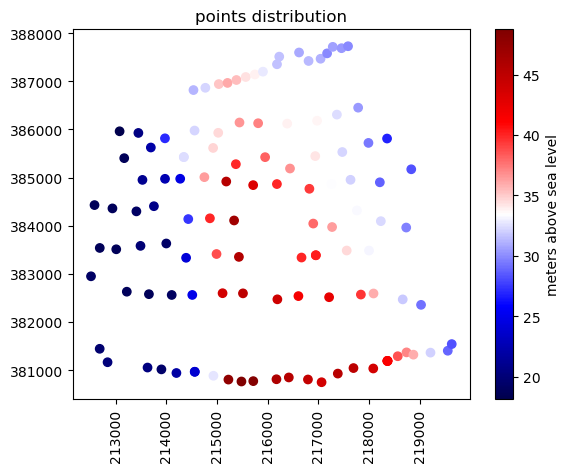

In [181]:
#observed data
plt.scatter(df['X'], df['Y'], c=df['Z'], cmap='seismic')
plt.xticks(rotation=90)
plt.colorbar(label="meters above sea level")
plt.title('points distribution')
plt.plot()
plt.show()

[]

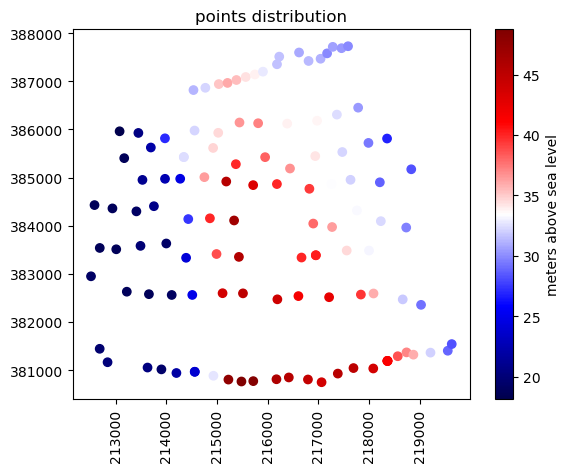

In [182]:
plt.scatter(df['X'], df['Y'], c=df['Z'], cmap='seismic')
plt.xticks(rotation=90)
plt.colorbar(label="meters above sea level")
plt.title('points distribution')
plt.plot()

In [183]:
#taking the size of the survey
dx = 250
dy = 250
dz = 250
xmin = 212000
xmax = 220001
ymin = 380000
ymax = 388001
zmin = 0.
zmax = 2501
x = np.arange(xmin, xmax, dx)
y = np.arange(ymin, ymax, dy)
z = np.arange(zmin, zmax, dz)
grid = pg.createGrid(x, y, z)
print(grid)


Mesh: Nodes: 11979 Cells: 10240 Boundaries: 32384


In [184]:
len(x)

33

In [185]:
len(y)

33

In [186]:
len(z)

11

(array([212000., 213000., 214000., 215000., 216000., 217000., 218000.,
        219000., 220000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

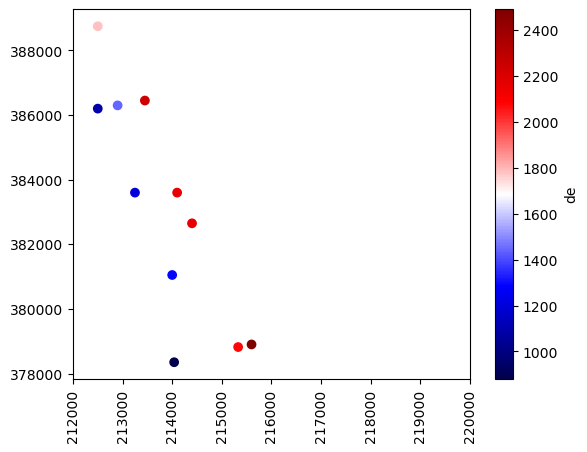

In [187]:
#some point locations of Viersen Fault

a =(
[214040,378350,880],
[215330,378820,2080],
[215600,378900,2490],
[214000,381050,1290],
[214400,382650,2160],
[213250,383600,1195],
[214100,383600,2160],
[212500,386200,1100],
[212900,386300,1440],
[213450,386450,2240],
[212500,388750,1780])

A=np.array(a)
Ax = A[:, 0]
Ay = A[:, 1]
Az = A[:, 2]

plt.scatter(Ax, Ay, c=Az,  cmap='seismic')
plt.xlim(212000, 220000)
plt.colorbar(label="de")
plt.xticks(rotation=90)

In [188]:
#Density distribution 
v = np.zeros((len(z)-1, len(y)-1, len(x)-1))
v[0:4]=3500
v[4:7]=2800
v[7:9]=2650
v[9]=2600

#for i in range(0, 33):
 # 
  #  v[8, (0+2*i):33, (15-i):33]=2600
   # v[6, (0+2*i):33, (13-i):33]=2650
    #v[3, (0+2*i):33, (12-i):33]=2800
#

v[0:10]=2400   
grid["synth"] = v.ravel()


We show the model making use of the pyvista package that can be called by
:py:func:`pygimli.show`. The mesh itself is shown as a wireframe, the anomaly
is plotted as a surface plot using a threshold filter. After the first call
with ``hold=True``, the plotter is used to draw any subsequent plots that can
also be slices or clips. Moreover, the camera position is set so that the
vertical axis is going downwards (x is Northing and y is Easting as common in
magnetics).




For the computation of the total field, we define the global magnetic
field using the IGRF (total field, inclination and declination) settings
given in the paper. Any global field can also be retrieved by the
``pyIGRF`` module.




In [189]:
#error estimation
#what about d_pre? taking the forward model
#for now default 
err = 1e-7
noise_level = 1e-4
relError = noise_level / np.abs(d_obs_grav) + err
d_obs_grav *= np.random.randn(*d_obs_grav.shape)*relError + 1.0

In [190]:
relError

0      1.001019e-07
1      1.001019e-07
2      1.001019e-07
3      1.001019e-07
4      1.001019e-07
           ...     
119    1.001019e-07
120    1.001019e-07
121    1.001019e-07
122    1.001019e-07
123    1.001019e-07
Length: 118, dtype: float64

In [191]:
#arranging data for the forward operator
d_obs_x=np.array(d_obs_x)
d_obs_y=np.array(d_obs_y)
d_obs_bouger=np.array(df['bouger anomaly'])
len(d_obs_bouger)

118

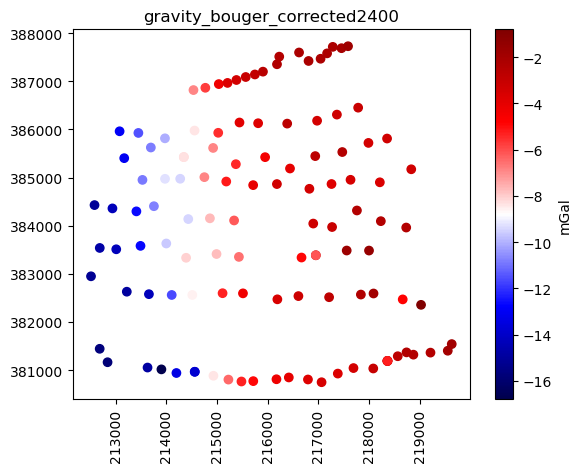

In [192]:
#observed bouger
plt.scatter(df['X'], df['Y'], c=d_obs_bouger, cmap='seismic')
plt.xticks(rotation=90)
plt.colorbar(label="mGal")
plt.title('gravity_bouger_corrected2400')
plt.plot()
plt.show()

In [193]:
points2 = np.column_stack((d_obs_x, d_obs_y, d_obs_bouger))

In [194]:
len(d_obs_x)

118

30/07/23 - 00:43:30 - Core - INFO - copy mesh for forward tasks.


   0%|          |0/118 [00:00 < ?]

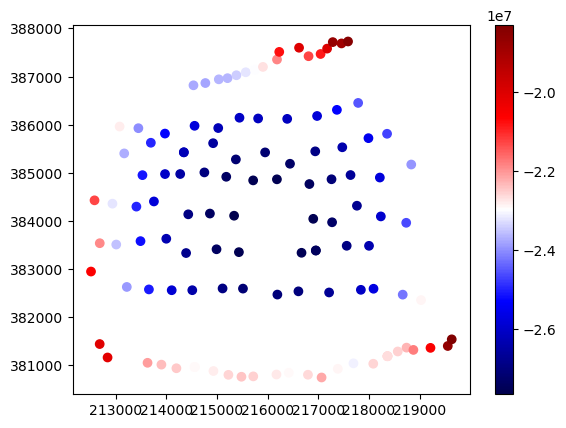

In [195]:
# forward operator based on the locations of the stations 
fop2 = GravityModelling(grid, points2)
data = fop2.response(grid["synth"])
noise_level = 0.1
data += np.random.randn(len(data)) * noise_level
#plt.contourf(xx, yy, np.reshape(data, xx.shape), cmap='seismic')
plt.scatter(d_obs_x, d_obs_y, c=data, cmap='seismic')
plt.colorbar();

In [196]:
data

118 [-22680132.865521315,...,-26250650.040022172]

## Depth weighting

In the paper of Li & Oldenburg (1996), they propose a depth weighting of the
constraints with the formula

\begin{align}w_z = \frac{1}{(z+z_0)^{3/2}}\end{align}




In [197]:
# depth weighting
bz = np.array([b.center().z() for b in grid.boundaries() if not b.outside()])
bn = np.array([b.norm().z() for b in grid.boundaries() if not b.outside()])
z0 = 100
wz = z0 / (bz+z0)**1
# wz = z0 / (pg.z(grid.cellCenters())+z0)

## Inversion

The inversion is rather straightforward using the standard inversion
framework :py:class:`pygimli.Inversion`.




In [198]:
#constraints variations
inv = pg.Inversion(fop=fop2, verbose=True)  # , debug=True)
inv.modelTrans = pg.trans.TransCotLU(2000, 3000)
inv.setRegularization(correlationLengths=[250, 250, 100])
inv.setConstraintWeights(wz)
invmodel = inv.run(data, lam=1e4,  # zWeight=0.3,
                   startModel=0.1, verbose=True)
grid["inv"] = invmodel

30/07/23 - 00:43:39 - pyGIMLi - INFO - Starting inversion.
30/07/23 - 00:43:39 - pyGIMLi - INFO - Creating GeostatisticConstraintsMatrix for region 0 with: I=[250, 250, 100], dip=0, strike=0
30/07/23 - 00:43:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
30/07/23 - 00:43:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


min/max(cWeight) = 0.040404/0.444444
min/max(dweight) = 3.61594e-06/5.46671e-06
fop: <__main__.GravityModelling object at 0x14f50b2ce3b0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x14f439957dc0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x14f4399764c0>
min/max (data): -2.8e+07/-1.8e+07
min/max (error): 1%/1%
min/max (start model): 0.1/0.1
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 3.61594e-06/5.46671e-06
Building constraints matrix


30/07/23 - 00:43:41 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 88725 Cells: 81920 Boundaries: 129536
Mesh contains data: synth


ModellingBase::setMesh() copying new mesh ... 0.540272 s
FOP updating mesh dependencies ... 2.0507e-05 s


30/07/23 - 00:43:48 - pyGIMLi - INFO - Cache /cvmfs/sys.hpc.itc.rwth-aachen.de/jupyter/clients/geophy/lib/python3.9/site-packages/pygimli/math/matrix.py:createCm05 restored (293.9s x 2): /home/yq015632/.cache/pygimli/10189171160265528618


constraint matrix of size(nBounds x nModel) 10240 x 10240
calculating jacobian matrix (forced=1)...... 8.643e-06 s
min data = -2.76553e+07 max data = -1.82926e+07 (118)
min error = 0.01 max error = 0.01 (118)
min response = -1152.3 max response = -762.19 (118)
calc without reference model
0: rms/rrms(data, response) = 2.44778e+07/99.9958%
0: chi^2(data, response, error, log) = 9999.17
0: Phi = 1.1799e+06 + 3.34942e-28 * 10000 = 1.1799e+06
--------------------------------------------------------------------------------
inv.iter 1 ... solve CGLSCDWWtrans with lambda = 10000
tau = 0. Trying parabolic line search with step length 0.3 ==> tau = 0.15
1: LS newModel: min = 1.27044e+24; max = 2.61173e+42
1: LS newResponse: min = -3.77551e+45; max = -4.99224e+43
1: rms/rrms(data, LS newResponse) = 6.30006e+44/2.31907e+39%
1: chi^2(data, LS newResponse, error, log) = 5.37808e+78
1: Phi = 6.34614e+80+0.416931*10000=6.34614e+80
Linesearch tau = 0.15
1: Model: min = 582.899; max = 325491
1: Respons

data_misfit
118 [3604.9712530002,...,9113.264797586948]
mean data_misfit
13850.857326902133
min data_misfit
1991.904127113521
max data_misfit
162953.00595657155


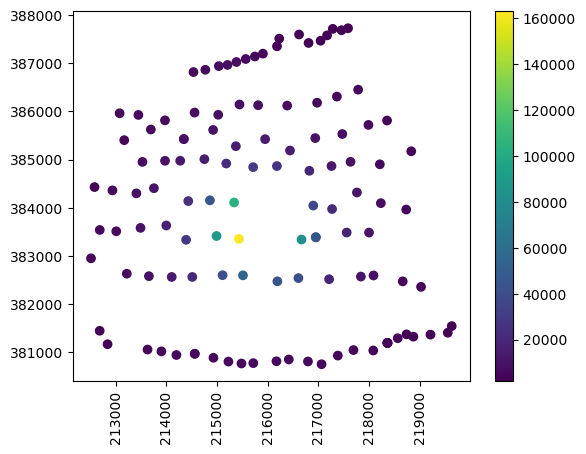

In [199]:
data_misfit=data-inv.response
#data_misfit, np.mean(data_misfit), min(data_misfit), max(data_misfit)

plt.scatter(d_obs_x,d_obs_y, c=data_misfit)
plt.colorbar()
plt.xticks(rotation=90)
#data_misfit, np.mean(data_misfit), min(data_misfit), max(data_misfit)
print('data_misfit')
print(data_misfit)
print('mean data_misfit')
print(np.mean(data_misfit))
print('min data_misfit')
print(min(data_misfit))
print('max data_misfit')
print(max(data_misfit))

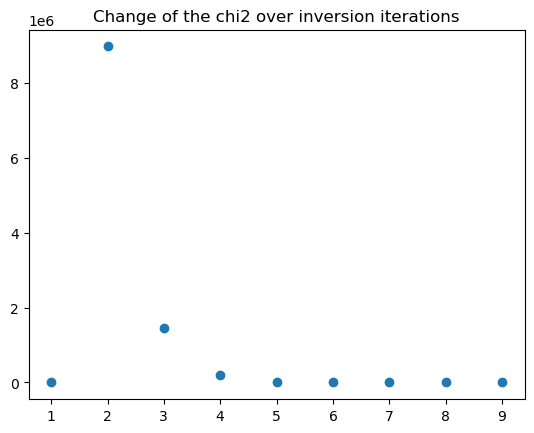

In [200]:
Xchi2=inv.chi2History
len(Xchi2)
n = len(Xchi2)  
iteration = np.arange(1, n + 1)
iteration
plt.title('Change of the chi2 over inversion iterations')
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(iteration,Xchi2)


In [201]:
Xchi2

[9999.16668402729,
 8981195.534925919,
 1461620.9756452153,
 204915.4506242285,
 23422.986869823555,
 2251.8117564117015,
 138.0004860927317,
 2.839592455175691,
 0.008857129908053091]

2023-07-30 00:44:56.754 (3153.622s) [        C13CD200]       vtkThreshold.cxx:87    WARN| vtkThreshold::ThresholdByUpper was deprecated for VTK 9.1 and will be removed in a future version.


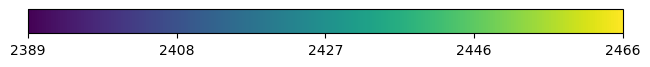

In [202]:
pl, _ = pg.show(grid, style="wireframe", hold=True, alpha=0.01)
pv.drawMesh(pl, grid, label="inv", style="surface", cMap="Spectral_r",
            filter={"threshold": dict(value=0.05, scalars="synth")})
pl.camera_position = "xz"
pl.camera.roll = 0
pl.camera.azimuth = 20
pl.camera.elevation = 50
pl.camera.zoom(1.2)
pg.viewer.mpl.createColorBarOnly(
    cMin=min(grid['inv']), cMax=max(grid['inv']),
    logScale=False, cMap=None, nLevs=5, label=None, orientation='horizontal', savefig=None, ax=None)
_ = pl.show()

In [203]:
#constraints variations
inv = pg.Inversion(fop=fop2, verbose=True)  # , debug=True)
inv.modelTrans = pg.trans.TransCotLU(2000, 2800)
inv.setRegularization(correlationLengths=[500, 500, 100])
inv.setConstraintWeights(wz)
invmodel = inv.run(data, lam=5e3,  # zWeight=0.3,
                   startModel=0.1, verbose=True)
grid["inv"] = invmodel

30/07/23 - 00:44:57 - pyGIMLi - INFO - Starting inversion.
30/07/23 - 00:44:57 - pyGIMLi - INFO - Creating GeostatisticConstraintsMatrix for region 0 with: I=[500, 500, 100], dip=0, strike=0


min/max(cWeight) = 0.040404/0.444444
min/max(dweight) = 3.61594e-06/5.46671e-06
fop: <__main__.GravityModelling object at 0x14f50b2ce3b0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x14f4980520a0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x14f4fd92d040>
min/max (data): -2.8e+07/-1.8e+07
min/max (error): 1%/1%
min/max (start model): 0.1/0.1
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 3.61594e-06/5.46671e-06
Building constraints matrix


30/07/23 - 00:45:03 - pyGIMLi - INFO - Cache /cvmfs/sys.hpc.itc.rwth-aachen.de/jupyter/clients/geophy/lib/python3.9/site-packages/pygimli/math/matrix.py:createCm05 restored (743.1s x 28): /home/yq015632/.cache/pygimli/13046752814859967862


constraint matrix of size(nBounds x nModel) 10240 x 10240
calculating jacobian matrix (forced=1)...... 1.2882e-05 s
min data = -2.76553e+07 max data = -1.82926e+07 (118)
min error = 0.01 max error = 0.01 (118)
min response = -1152.3 max response = -762.19 (118)
calc without reference model
0: rms/rrms(data, response) = 2.44778e+07/99.9958%
0: chi^2(data, response, error, log) = 9999.17
0: Phi = 1.1799e+06 + 6.9066e-28 * 5000 = 1.1799e+06
--------------------------------------------------------------------------------
inv.iter 1 ... solve CGLSCDWWtrans with lambda = 5000
tau = 0. Trying parabolic line search with step length 0.3 ==> tau = 0.15
1: LS newModel: min = 1.09152e+45; max = 1.26911e+61
1: LS newResponse: min = -2.71499e+63; max = -4.44241e+61
1: rms/rrms(data, LS newResponse) = 6.84764e+62/2.61602e+57%
1: chi^2(data, LS newResponse, error, log) = 6.84354e+114
1: Phi = 8.07538e+116+1.25504*5000=8.07538e+116
Linesearch tau = 0.15
1: Model: min = 804831; max = 2.06788e+08
1: Resp

data_misfit
118 [6343.663819614798,...,14798.903302948922]
mean data_misfit
22129.959942351237
min data_misfit
3313.0172889977694
max data_misfit
202147.42681968585


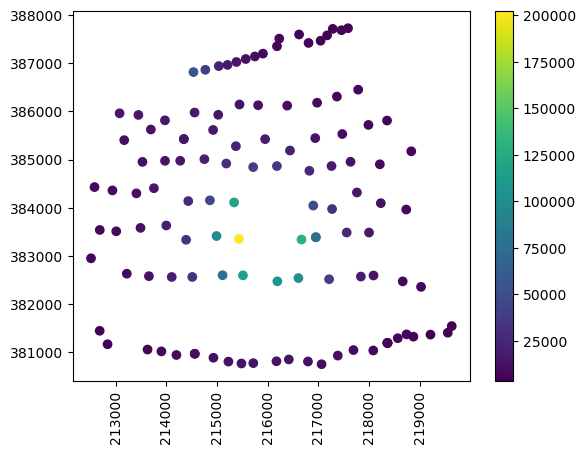

In [204]:
data_misfit=data-inv.response
#data_misfit, np.mean(data_misfit), min(data_misfit), max(data_misfit)

plt.scatter(d_obs_x,d_obs_y, c=data_misfit)
plt.colorbar()
plt.xticks(rotation=90)
#data_misfit, np.mean(data_misfit), min(data_misfit), max(data_misfit)
print('data_misfit')
print(data_misfit)
print('mean data_misfit')
print(np.mean(data_misfit))
print('min data_misfit')
print(min(data_misfit))
print('max data_misfit')
print(max(data_misfit))

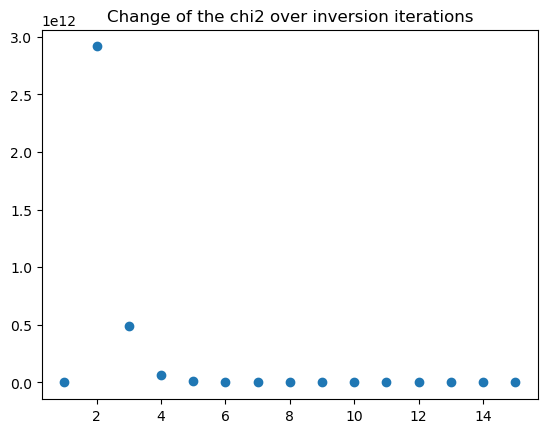

In [205]:
chi2=inv.chi2History
len(chi2)
n = len(chi2)  
iteration = np.arange(1, n + 1)
iteration
plt.title('Change of the chi2 over inversion iterations')
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(iteration,chi2)


In [206]:
chi2

[9999.16668402729,
 2915370282978.476,
 486402344701.8619,
 68369025213.00875,
 9308123711.693644,
 1260571121.468207,
 170059105.94528183,
 22789563.915936235,
 3004281.5909987926,
 380322.0827608356,
 50786.95261118434,
 5042.53486792147,
 334.2872109835008,
 7.285246036288401,
 0.019479414569250904]

2023-07-30 00:46:44.672 (3261.540s) [        C13CD200]       vtkThreshold.cxx:87    WARN| vtkThreshold::ThresholdByUpper was deprecated for VTK 9.1 and will be removed in a future version.


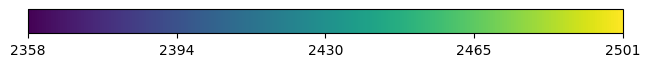

In [207]:
pl, _ = pg.show(grid, style="wireframe", hold=True, alpha=0.01)
pv.drawMesh(pl, grid, label="inv", style="surface", cMap="Spectral_r",
            filter={"threshold": dict(value=0.05, scalars="synth")})

pl.camera_position = "xz"
pl.camera.roll = 0
pl.camera.azimuth = 20
pl.camera.elevation = 50
pl.camera.zoom(1.2)
pg.viewer.mpl.createColorBarOnly(
    cMin=min(grid['inv']), cMax=max(grid['inv']),
    logScale=False, cMap=None, nLevs=5, label=None, orientation='horizontal', savefig=None, ax=None)
_ = pl.show()

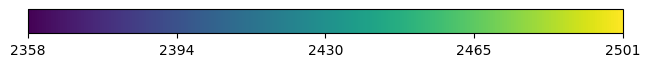

In [208]:

pl, _ = pg.show(grid, hold=True, alpha=0.3)
drawSlice(pl, grid, normal=[1.75,1.75,0], label="inv")

pg.viewer.mpl.createColorBarOnly(
    cMin=min(grid['inv']), cMax=max(grid['inv']),
    logScale=False, cMap=None, nLevs=5, label=None, orientation='horizontal', savefig=None, ax=None)
_ = pl.show()



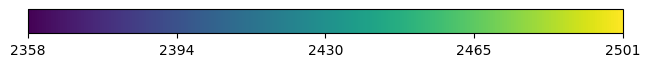

In [209]:

pl, _ = pg.show(grid, hold=True, alpha=0.3)
drawSlice(pl, grid, normal=[0,1.75,0], label="inv")
drawSlice(pl, grid, normal=[1,0,0], label="inv")
drawSlice(pl, grid, normal=[1,1,0], label="inv")
drawSlice(pl, grid, normal=[-1,1,0], label="inv")
pg.viewer.mpl.createColorBarOnly(
    cMin=min(grid['inv']), cMax=max(grid['inv']),
    logScale=False, cMap=None, nLevs=5, label=None, orientation='horizontal', savefig=None, ax=None)
_ = pl.show()



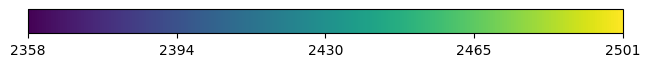

In [210]:

pl, _ = pg.show(grid, hold=True, alpha=0.3)
drawSlice(pl, grid, normal=[1,0,0], label="inv")

pg.viewer.mpl.createColorBarOnly(
    cMin=min(grid['inv']), cMax=max(grid['inv']),
    logScale=False, cMap=None, nLevs=5, label=None, orientation='horizontal', savefig=None, ax=None)
_ = pl.show()



In [211]:
### grid.exportVTK('vtk')

In [212]:
#constraints variations
inv = pg.Inversion(fop=fop2, verbose=True)  # , debug=True)
inv.modelTrans = pg.trans.TransCotLU(2000, 2800)
inv.setRegularization(correlationLengths=[50, 50, 10])
inv.setConstraintWeights(wz)
invmodel = inv.run(data, lam=5e3,  # zWeight=0.3,
                   startModel=0.1, verbose=True)
grid["inv"] = invmodel

30/07/23 - 00:46:47 - pyGIMLi - INFO - Starting inversion.
30/07/23 - 00:46:47 - pyGIMLi - INFO - Creating GeostatisticConstraintsMatrix for region 0 with: I=[50, 50, 10], dip=0, strike=0


min/max(cWeight) = 0.040404/0.444444
min/max(dweight) = 3.61594e-06/5.46671e-06
fop: <__main__.GravityModelling object at 0x14f50b2ce3b0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x14f439ab34c0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x14f4980520a0>
min/max (data): -2.8e+07/-1.8e+07
min/max (error): 1%/1%
min/max (start model): 0.1/0.1
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 3.61594e-06/5.46671e-06
Building constraints matrix


30/07/23 - 00:46:53 - pyGIMLi - INFO - Cache /cvmfs/sys.hpc.itc.rwth-aachen.de/jupyter/clients/geophy/lib/python3.9/site-packages/pygimli/math/matrix.py:createCm05 restored (525.3s x 3): /home/yq015632/.cache/pygimli/9986530352742534309


constraint matrix of size(nBounds x nModel) 10240 x 10240
calculating jacobian matrix (forced=1)...... 1.2343e-05 s
min data = -2.76553e+07 max data = -1.82926e+07 (118)
min error = 0.01 max error = 0.01 (118)
min response = -1152.3 max response = -762.19 (118)
calc without reference model
0: rms/rrms(data, response) = 2.44778e+07/99.9958%
0: chi^2(data, response, error, log) = 9999.17
0: Phi = 1.1799e+06 + 2.69164e-28 * 5000 = 1.1799e+06
--------------------------------------------------------------------------------
inv.iter 1 ... solve CGLSCDWWtrans with lambda = 5000


30/07/23 - 00:47:05 - Core - ERROR - Model contains nan values.
30/07/23 - 00:47:06 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.Inversion'>.run(inversion.py:676)
One step failed. Aborting and going back to last model


./core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf
chi² = 9999.17 (dPhi = 0.0%) lam: 5000.0
--------------------------------------------------------------------------------
inv.iter 2 ... calculating jacobian matrix (forced=1)...... 1.2266e-05 s
solve CGLSCDWWtrans with lambda = 5000


30/07/23 - 00:47:18 - Core - ERROR - Model contains nan values.
30/07/23 - 00:47:18 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.Inversion'>.run(inversion.py:676)
One step failed. Aborting and going back to last model


./core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf
chi² = 9999.17 (dPhi = 0.0%) lam: 5000.0
--------------------------------------------------------------------------------
inv.iter 3 ... calculating jacobian matrix (forced=1)...... 1.2113e-05 s
solve CGLSCDWWtrans with lambda = 5000


30/07/23 - 00:47:30 - Core - ERROR - Model contains nan values.
30/07/23 - 00:47:31 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.Inversion'>.run(inversion.py:676)
One step failed. Aborting and going back to last model


./core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf
chi² = 9999.17 (dPhi = 0.0%) lam: 5000.0
--------------------------------------------------------------------------------
inv.iter 4 ... calculating jacobian matrix (forced=1)...... 1.2021e-05 s
solve CGLSCDWWtrans with lambda = 5000


30/07/23 - 00:47:45 - Core - ERROR - Model contains nan values.
30/07/23 - 00:47:46 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.Inversion'>.run(inversion.py:676)
One step failed. Aborting and going back to last model


./core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf
chi² = 9999.17 (dPhi = 0.0%) lam: 5000.0
################################################################################
#                 Abort criteria reached: dPhi = 0.0 (< 2.0%)                  #
################################################################################


2023-07-30 00:47:46.590 (3323.458s) [        C13CD200]       vtkThreshold.cxx:87    WARN| vtkThreshold::ThresholdByUpper was deprecated for VTK 9.1 and will be removed in a future version.


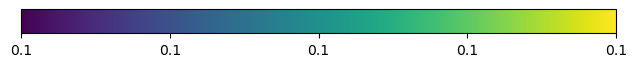

In [213]:
pl, _ = pg.show(grid, style="wireframe", hold=True, alpha=0.01)
pv.drawMesh(pl, grid, label="inv", style="surface", cMap="Spectral_r",
            filter={"threshold": dict(value=0.05, scalars="synth")})
pl.camera_position = "xz"
pl.camera.roll = 0
pl.camera.azimuth = 20
pl.camera.elevation = 50
pl.camera.zoom(1.2)
pg.viewer.mpl.createColorBarOnly(
    cMin=min(grid['inv']), cMax=max(grid['inv']),
    logScale=False, cMap=None, nLevs=5, label=None, orientation='horizontal', savefig=None, ax=None)
_ = pl.show()

In [ ]:
slice = pg.meshtools.extract2dSlice(grid, origin=[xmin, ymin, zmin], normal=[1, 1, 0])
_, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
pg.show(slice, "synth", ax=ax[0])
pg.show(slice, "inv", ax=ax[1])
ax[0].set_ylim(ax[0].get_ylim()[::-1])

## References
-  Li, Y. & Oldenburg, D. (1998): 3-D inversion of gravity data. Geophysics 63(1), 109-119.
-  Holstein, H., Sherratt, E.M., Reid, A.B.  (2007): Gravimagnetic field
   tensor gradiometry formulas for uniform polyhedra, SEG Ext. Abstr.


